# GP Kernel Experiments for Mobility Data Analysis

For our culminating project, we apply predictive models on human mobility data using Gaussian processes. Specifically, we are interested in predicting a given person's location using features from their dataset.

## Library Loading & Data Pre-Processing

In [ ]:
from google.colab import drive

# the following command loads up your google drive. It will promp you to give Colab access to your Gdrive
drive.mount('/content/drive')

FOLDERNAME = ""
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/AMATH 482/Homework 5


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import math
import numpy as np
from typing import Optional
import warnings

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import torch
from torch import nn, Tensor
from torch.nn import functional as F

!pip install gpytorch

import gpytorch
from gpytorch.constraints.constraints import Interval, Positive
from gpytorch.kernels.kernel import Kernel
from gpytorch.priors.prior import Prior
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
# Run this line every time in order to refresh the data
# All data sets can be used, but not all are suitable for the kernel
df = pd.read_csv('processed/user_0162bdca5925e11a37a48c507453734045b5d62cca0d6abc8300993dfbf8b69e.csv') # 462 observations w/ 21 unique locations (best performance)
#df = pd.read_csv('processed/user_0168d97c1ca0723b715aebbc073fc1467a14ce3e7c503f4d6abfd423283292bc.csv') # 340 observations w/ 41 unique locations (poor performance)
#df = pd.read_csv('processed/user_0162d8fd57dd8e7ce0ceb9209ab78e5d3619948e70477fbd95d5c746baa564ff.csv') # 333 observations w/ 54 unique locations (poor performance)
#df = pd.read_csv('processed/user_01642b85e6773cfbbc3a588c42dffd5db6df684c5965976c7ab0bfd57d7729e8.csv') # 326 observations w/ 85 unique locations (poor performance)
#df = pd.read_csv('processed/user_0166568f9c803f70727a6fb01aea245056f51c3d951211d95826508a2a5d0d5c.csv') # 234 observations w/ 60 unique locations (poor performance)
#df = pd.read_csv('processed/user_016addadda73ffb46e0b0b6c9b365f995437d01470b782268c87931d0e250c97.csv') # 151 observations w/ 26 unique locations (poor performance)
#df = pd.read_csv('processed/user_0169078d983de51eeebfca64093e45ec1d5e73d49eae62239164341560bfe178.csv') # 132 observations w/ 19 unique locations (poor performance)
#df = pd.read_csv('processed/user_01676e311de53336910c520f49f9c0cffc949a546885dc14f9c22d170887cb39.csv') # 78 observations w/ 34 unique locations (poor performance)
#df = pd.read_csv('processed/user_0167f0fc8edaa27ee9c3d76423c845f164e033625e459d4397fb01898c866d5e.csv') # 63 observations w/ 14 unique locations (poor performance)
#df = pd.read_csv('processed/user_01684fd6a43a1f89a8ee2073cdfdb91a8bce5b40a45f25b137d3c7db8c9cc974.csv') # 29 observations w/ 3 unique locations (poor performance)

# Pre-process the data
# Add additional corrections as needed
df['last_one'] = df['last_one'].fillna(-1)
df['last_two'] = df['last_two'].apply(lambda x: np.fromstring(x[1 : len(x) - 1], dtype = float, sep = ','))
df['last_three'] = df['last_three'].apply(lambda x: np.fromstring(x[1 : len(x) - 1], dtype = float, sep = ','))
df['last_three_activity_duration'] = df['last_three_activity_duration'].apply(lambda x: np.fromstring(x[1 : len(x) - 1], dtype = float, sep = ','))
df['last_start_time'] = pd.to_datetime(df['last_start_time'])
df['leaving_datetime'] = pd.to_datetime(df['leaving_datetime'])

# Add additional features
df['leaving_hour'] = df['leaving_datetime'].dt.hour.astype(int)
df['day_of_week'] = df['leaving_datetime'].dt.dayofweek # Monday = 0, Sunday = 6
df['is_weekday'] = df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)

# Used for data encoding comparisons
df['third_last_one'] = df['last_three'].apply(lambda x: x[2]).fillna(-1)
df['second_last_one'] = df['last_two'].apply(lambda x: x[1]).fillna(-1)

# View the data
pd.options.display.max_columns = None
df.head()

,datetime,leaving_datetime,cluster,dist,last_one,last_two,last_three,activity_duration,last_three_activity_duration,last_three_start_time,last_three_end_time,last_three_lat,last_three_lng,last_three_dist,last_dist,second_last_dist,third_last_dist,last_start_time,second_last_start_time,third_last_start_time,last_end_time,second_last_end_time,third_last_end_time,last_activity_duration,second_last_activity_duration,third_last_activity_duration,leaving_hour,day_of_week,is_weekday,third_last_one,second_last_one
0,2019-12-31 14:49:22,2019-12-31 15:58:02,0,58813.0,-1.0,"[nan, nan]","[nan, nan, nan]",69,"[nan, nan, nan]","(NaT, NaT, NaT)","(NaT, NaT, NaT)","(nan, nan, nan)","(nan, nan, nan)","(nan, nan, nan)",NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,1,1,-1.0,-1.0
1,2019-12-31 17:01:04,2019-12-31 19:45:05,6,52032.0,0.0,"[0.0, nan]","[0.0, nan, nan]",164,"[69.0, nan, nan]","(Timestamp('2019-12-31 14:49:22'), NaT, NaT)","(Timestamp('2019-12-31 15:58:02'), NaT, NaT)","(47.22057343, nan, nan)","(-122.3467407, nan, nan)","(58813.0, nan, nan)",58813.0,NaN,NaN,2019-12-31 14:49:22,NaN,NaN,2019-12-31 15:58:02,NaN,NaN,69.0,NaN,NaN,19,1,1,-1.0,-1.0
2,2019-12-31 20:32:41,2020-01-01 01:35:33,3,38063.0,6.0,"[6.0, 0.0]","[6.0, 0.0, nan]",303,"[164.0, 69.0, nan]","(Timestamp('2019-12-31 17:01:04'), Timestamp('...","(Timestamp('2019-12-31 19:45:05'), Timestamp('...","(47.518939, 47.22057343, nan)","(-121.84213555, -122.3467407, nan)","(52032.0, 58813.0, nan)",52032.0,58813.0,NaN,2019-12-31 17:01:04,2019-12-31 14:49:22,NaN,2019-12-31 19:45:05,2019-12-31 15:58:02,NaN,164.0,69.0,NaN,1,2,1,-1.0,0.0
3,2020-01-01 02:41:51,2020-01-02 08:52:52,0,4705.0,3.0,"[3.0, 6.0]","[3.0, 6.0, 0.0]",1811,"[303.0, 164.0, 69.0]","(Timestamp('2019-12-31 20:32:41'), Timestamp('...","(Timestamp('2020-01-01 01:35:33'), Timestamp('...","(47.8473012, 47.518939, 47.22057343)","(-122.2763971, -121.84213555, -122.3467407)","(38063.0, 52032.0, 58813.0)",38063.0,52032.0,58813.0,2019-12-31 20:32:41,2019-12-31 17:01:04,2019-12-31 14:49:22,2020-01-01 01:35:33,2019-12-31 19:45:05,2019-12-31 15:58:02,303.0,164.0,69.0,8,3,1,0.0,6.0
4,2020-01-02 09:21:03,2020-01-02 14:45:51,1,4705.0,0.0,"[0.0, 3.0]","[0.0, 3.0, 6.0]",325,"[1811.0, 303.0, 164.0]","(Timestamp('2020-01-01 02:41:51'), Timestamp('...","(Timestamp('2020-01-02 08:52:52'), Timestamp('...","(47.22057343, 47.8473012, 47.518939)","(-122.3467407, -122.2763971, -121.84213555)","(4705.0, 38063.0, 52032.0)",4705.0,38063.0,52032.0,2020-01-01 02:41:51,2019-12-31 20:32:41,2019-12-31 17:01:04,2020-01-02 08:52:52,2020-01-01 01:35:33,2019-12-31 19:45:05,1811.0,303.0,164.0,14,3,1,6.0,3.0


Some notes:

- Clusters are unnamed locations with cluster 0 as the most frequently visited, decreasing in visitation frequency as cluster value increases. In general, we interpret cluster 0 as home.

- The values last_one, last_two, and last_three are sequences in theory, but in application, are tuples that are treated as a single unit. As such, I broke down those values and explore patterns using last_one, second_last_one, and third_last_one as individual location representations. We have empirical evidence that there is better predicitive power when considering the similarity of trip locations as a sequence. For instance, finding similarity between [0, 1, 2] and [0, 1, 3] shows us that we have similarity 2 out of three as opposed to having 0 similarity in terms of a black-and-white approach.

## Convenience Functions

### Frequency Map

In order to assist in the analysis of our results, we employ a frequency map. Given every combination of the input features, we tally the number of outputs, thus recording the conditional frequency of the target given the inputs.

In [ ]:
# The features we wish to learn from
features = ['last_one', 'second_last_one', 'third_last_one', 'leaving_hour', 'day_of_week']
df['features_hash'] = df[features].apply(lambda x: hash(tuple(x)), axis=1)

# create a hashmap which maps each features hash to another hashmap
# which maps each cluster to the frequency of that cluster
frequency_map = {}
for i in range(len(df)):
    feature_hash = df['features_hash'][i]
    cluster = df['cluster'][i]
    if feature_hash not in frequency_map:
        frequency_map[feature_hash] = {}
        frequency_map[feature_hash][cluster] = 1
    else:
        if cluster not in frequency_map[feature_hash]:
            frequency_map[feature_hash][cluster] = 1
        else:
            frequency_map[feature_hash][cluster] += 1

# uncomment below line if you wish to see the (messy) frequency map
# frequency_map

### Calculate Accuracy

Simple function to calculate accuracy. Set show_mat to true if you want to see the prediction matrix.

In [ ]:
def calculate_acc(pred, actual, show_mat=False):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    if show_mat == True:
      display(torch.tensor(actual - pred, dtype=torch.int))
    return (len(actual) - torch.count_nonzero(torch.tensor(actual - pred, dtype=torch.int))) / len(actual)

## Random Forest Baseline

First, we wish to establish a strong baseline to make quality comparisons against. Random Forest classifiers are a common and effective way of accurately predicting classes (in our case, someone's next location). See https://link.springer.com/chapter/10.1007/978-3-030-03146-6_86 for more information.

### Source Code

In [ ]:
# The features we wish to learn from
features = ['last_one', 'second_last_one', 'leaving_hour', 'day_of_week']

class RandomForest:
    """
    A majority vote random forest classifier
    """

    def __init__(self, num_trees, max_depth=None):
        """
        Constructs a RandomForest that uses the given number of trees, each with a
        max depth of max_depth.
        """
        self._trees = [
            DecisionTreeClassifier(max_depth=max_depth, random_state=1)
            for i in range(num_trees)
        ]

    def fit(self, X):
        """
        Takes an input dataset X and trains each tree on a random subset of the data.
        Sampling is done with replacement.
        """

        for mini_tree in self._trees:
            mini_data = X.iloc[np.random.randint(0, X.shape[0], X.shape[0])]
            mini_tree.fit(mini_data[features], mini_data['cluster'])

    def predict(self, X):
        """
        Takes an input dataset X and returns the predictions for each example in X.
        """
        # Builds up a 2d array with n rows and T columns
        # where n is the number of points to classify and T is the number of trees
        predictions = np.zeros((len(X), len(self._trees)))
        for i, tree in enumerate(self._trees):
            # Make predictions using the current tree
            preds = tree.predict(X)

            # Store those predictions in ith column of the 2d array
            predictions[:, i] = preds

        # For each row of predictions, find the most frequent label (axis=1 means across columns)
        return scipy.stats.mode(predictions, axis=1, keepdims=False)[0]

### Experiment

In [ ]:
# Get training and testing data
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

train_set, val_set = train_test_split(train_set, test_size = 0.3, random_state = 84)

# Get x data
x_train = train_set[features].values
x_val = val_set[features].values
x_test = test_set[features].values

# Convert cluster column to tensor
y_train = train_set['cluster'].values
y_val = val_set['cluster'].values
y_test = test_set['cluster'].values

print("training shape:", y_train.shape)
print("validation shape:", y_val.shape)
print("testing shape:", y_test.shape)

training shape: (258,)
validation shape: (111,)
testing shape: (93,)


First we train and optimize our random forest baseline on the validation set.

In [ ]:
from sklearn.model_selection import cross_val_score

# First calculate the accuracies for each depth
rf_acc_list = []
depths = list(range(1, 26, 2))
trees = list(range(1, 26, 2))
best_depth = 0
best_trees = 0
best_accuracy = 0
best_pred = None
best_forest = None

for i in depths:
  for j in trees:
    # Train and evaluate our RandomForest classifier with given max_depth
    forest = RandomForest(num_trees=j, max_depth=i)
    forest.fit(train_set)

    train_score = accuracy_score(forest.predict(train_set[features]), y_train)
    observed_pred = forest.predict(val_set[features])
    val_score = accuracy_score(observed_pred, y_val)
    rf_acc_list.append(val_score)

    if val_score > best_accuracy:
        best_accuracy = val_score
        best_depth = i
        best_trees = j
        best_pred = observed_pred
        best_forest = forest

print("Best Validation Accuracy: ", best_accuracy, "\nBest Validation Depth: ", best_depth, "\nBest Number of Trees: ", best_trees, sep="")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("Prediction Error Tensor: ")
    display(torch.tensor(y_val - best_pred, dtype=torch.int))


Best Validation Accuracy: 0.8918918918918919
Best Validation Depth: 7
Best Number of Trees: 5
Prediction Error Tensor: 


tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,   1,   1,   0,   0,   0,   0,   0,   0,   0,   4,   0,  12,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   5,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  -6, -14,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  10,
          0,   0,   0,  20,   0,   0,   0,   0,   0,   0,   6,   0,   0],
       dtype=torch.int32)

Plot our our model selection

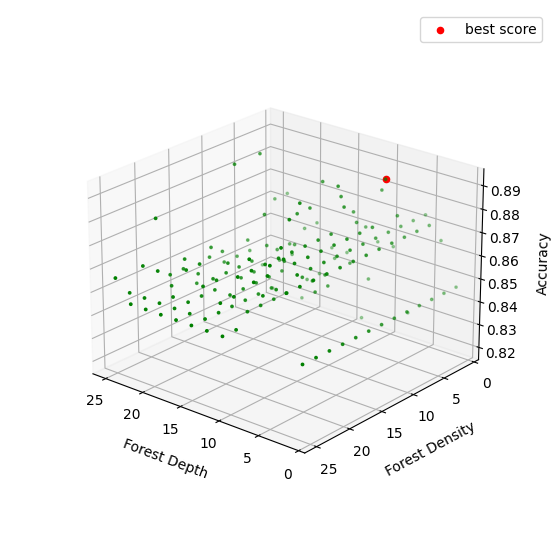

In [ ]:
# plot 3-PC space
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.set_box_aspect(aspect=None, zoom=0.8)
for i in range(13):
  ax.scatter(depths[i] * np.ones(13), trees, rf_acc_list[13*i: 13*(i + 1)], c='green',  s=3)
ax.scatter(best_depth, best_trees, best_accuracy, c='red',  s=20, label='best score')
ax.set_xlabel('Forest Depth', labelpad=12)
ax.set_ylabel('Forest Density', labelpad=12)
ax.set_zlabel('Accuracy', labelpad=12)
ax.legend()
ax.view_init(23, 130)

Now we test our random forest classifier.

In [ ]:
test_pred = best_forest.predict(test_set[features])
test_score = accuracy_score(test_pred, y_test)

print("Test Accuracy: ", test_score, sep="")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("Prediction Error Tensor: ")
    display(torch.tensor(y_test - test_pred, dtype=torch.int))

Test Accuracy: 0.8817204301075269
Prediction Error Tensor: 


tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  8,
         1, -1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0, -1,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0], dtype=torch.int32)

### Analysis

To further analyze our baseline, we use the frequency map to help determine how far off our prediction was from the base result.

In [ ]:
y_test - test_pred

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  0.,  0.,  8.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
       -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])

In [ ]:
hashcodes = test_set['features_hash'].values

for i in range(len(y_test)):
  actual = y_test[i]
  predicted = test_pred[i].astype(int)
  if actual - predicted != 0:
    actual_freq = frequency_map[hashcodes[i]][actual]

    # We must also account for if/when best_pred[i] is not a cluster label.
    # For instance, the hashcode at index 17 has no mapping to best_pred[17] = 2.
    # As such, we will prevent the code from running and instead set the value to 0.
    if predicted not in frequency_map[hashcodes[i]]:
      pred_freq = 0
    else:
        pred_freq = frequency_map[hashcodes[i]][predicted]
    print("------------------------------------------------------------------------------------>")
    print("actual_freq: ", actual_freq)
    print("pred_freq: ", pred_freq)
    print("(index: ", i, ") (y_actual: ", actual, ") (RF_pred: ", predicted, ") (actual - predicted frequency: ", actual_freq - pred_freq, ")", sep="")

------------------------------------------------------------------------------------>
actual_freq:  1
pred_freq:  3
(index: 14) (y_actual: 2) (RF_pred: 0) (actual - predicted frequency: -2)
------------------------------------------------------------------------------------>
actual_freq:  1
pred_freq:  0
(index: 17) (y_actual: 10) (RF_pred: 2) (actual - predicted frequency: 1)
------------------------------------------------------------------------------------>
actual_freq:  3
pred_freq:  0
(index: 18) (y_actual: 3) (RF_pred: 2) (actual - predicted frequency: 3)
------------------------------------------------------------------------------------>
actual_freq:  1
pred_freq:  0
(index: 19) (y_actual: 0) (RF_pred: 1) (actual - predicted frequency: 1)
------------------------------------------------------------------------------------>
actual_freq:  1
pred_freq:  0
(index: 26) (y_actual: 1) (RF_pred: 0) (actual - predicted frequency: 1)
-----------------------------------------------------

As we can see, the random forest classifier does a strong job of keeping the actual and predicted frequencies fairly close. Even though some locations were inaccurately predicted, we were still choosing locations that were almost as frequent given the specific combination of input features.

## Dirichlet GP Classification Experiments

Dirichlet classification is a useful method for GP classification problems. In general, GP classification methods are expensive to run, which hinder many applications to large-scale multi-class classification problems. However, the Dirichlet GP classification method allows us to perform regression on the labels which "leads to fast training and excellent classification accuracies... without compromising on calibration" (Milios et. al., 2018). The theory can be explored in this article: https://papers.nips.cc/paper/2018/file/b6617980ce90f637e68c3ebe8b9be745-Paper.pdf

### Introducing Sequences

Expanding upon the previous model's discussion, we implement one-hot encoding as a way into our location variables as a way to transform our weighted locations into labels. We then append the leaving hour of day and day of week manually

In [ ]:
dummies2 = pd.get_dummies(df['second_last_one']).values
dummies3 = pd.get_dummies(df['last_one']).values

# May be used for experiments, but does not improve the results
dummies1 = pd.get_dummies(df['third_last_one']).values
dummies4 = pd.get_dummies(df['leaving_hour']).values
dummies5 = pd.get_dummies(df['day_of_week']).values

# connect old data fram with new one horizontally
new_df = pd.concat([df,
                    pd.DataFrame(dummies2),
                    pd.DataFrame(dummies3),
                    pd.DataFrame(df['leaving_hour']),
                    pd.DataFrame(df['day_of_week'])], axis=1)
train_set, test_set = train_test_split(new_df, test_size = 0.2, random_state=42)
train_set, _ = train_test_split(train_set, test_size = 0.3, random_state = 84)

# The length of our input tensor
input_length = dummies2.shape[1] + dummies3.shape[1]

# x_train is last input_length columns of train_set + 2 columns for hour and day
x_train = torch.tensor(train_set.iloc[:, -(input_length + 2):].values, dtype=torch.int64)
print("training shape:", x_train.shape)

# x_test is last input_length columns of test_set + 2 columns for hour and day
x_test = torch.tensor(test_set.iloc[:, -(input_length + 2):].values, dtype=torch.int64)
print("testing shape:", x_test.shape)

# Convert cluster column to tensor
y_train = torch.tensor(train_set['cluster'].values, dtype=torch.int64)
y_actual = torch.tensor(test_set['cluster'].values, dtype=torch.int64)

training shape: torch.Size([258, 46])
testing shape: torch.Size([93, 46])


In [ ]:
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,))
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(y_train, learn_additional_noise=True)
model = DirichletGPModel(x_train, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

# Use the adam optimizer and marginal log likelihood loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [ ]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
epochs = 2 if smoke_test else 150

# Find optimal model hyperparameters
model.train()
likelihood.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if epoch % 15 == 0:
        print('Iter %d/%d - Loss: %.3f' % (epoch + 1, epochs, loss.item()))
    optimizer.step()

Iter 1/150 - Loss: 84.201
Iter 16/150 - Loss: 44.586
Iter 31/150 - Loss: 39.493
Iter 46/150 - Loss: 38.057
Iter 61/150 - Loss: 37.492
Iter 76/150 - Loss: 37.197
Iter 91/150 - Loss: 37.000
Iter 106/150 - Loss: 36.850
Iter 121/150 - Loss: 36.730
Iter 136/150 - Loss: 36.630


In [ ]:
# evaluate our model
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_outputs = model(x_test)

print("We predict the next location (current cluster) with an accuracy of: ",
            '%.2f'%(calculate_acc(test_outputs.loc.max(0)[1], y_test, True).item() * 100), "%", sep="")

tensor([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 5, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)

We predict the next location (current cluster) with an accuracy of: 89.25%


In [ ]:
with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      print("Location Error: ", '%d'%((torch.sum(torch.abs(torch.tensor(y_test - test_outputs.loc.max(0)[1], dtype=torch.int))))), sep="")

Location Error: 16


Per the difference matrix above, we interpret this as:
- 0's being correct predictions
- Positive values being undershot predictions (chose something less frequent)
- Negative values being overshot predictions (chose something more frequent)

### Analysis

To further analyze our GP model, we use the frequency map to help determine how far off our prediction was from the actual result.

In [ ]:
hashcodes = test_set['features_hash'].values

for i in range(len(y_actual)):
    actual = y_actual[i].int().item()
    predicted = test_outputs.loc.max(0)[1][i].int().item()
    if actual - predicted != 0:
        actual_freq = frequency_map[hashcodes[i]][actual]

        # We must also account for if/when best_pred[i] is not a cluster label.
        # For instance, the hashcode at index 17 has no mapping to best_pred[17] = 2.
        # As such, we will prevent the code from running and instead set the value to 0.
        if predicted not in frequency_map[hashcodes[i]]:
            pred_freq = 0
        else:
            pred_freq = frequency_map[hashcodes[i]][predicted]
        print("------------------------------------------------------------------------------------>")
        print("actual_freq: ", actual_freq)
        print("pred_freq: ", pred_freq)
        print("(index: ", i, ") (y_actual: ", actual, ") (GP_pred: ", predicted, ") (actual - predicted frequency: ", actual_freq - pred_freq, ")", sep="")

------------------------------------------------------------------------------------>
actual_freq:  2
pred_freq:  0
(index: 4) (y_actual: 2) (GP_pred: 0) (actual - predicted frequency: 2)
------------------------------------------------------------------------------------>
actual_freq:  1
pred_freq:  3
(index: 14) (y_actual: 2) (GP_pred: 0) (actual - predicted frequency: -2)
------------------------------------------------------------------------------------>
actual_freq:  1
pred_freq:  0
(index: 17) (y_actual: 10) (GP_pred: 5) (actual - predicted frequency: 1)
------------------------------------------------------------------------------------>
actual_freq:  3
pred_freq:  0
(index: 18) (y_actual: 3) (GP_pred: 2) (actual - predicted frequency: 3)
------------------------------------------------------------------------------------>
actual_freq:  1
pred_freq:  0
(index: 26) (y_actual: 1) (GP_pred: 0) (actual - predicted frequency: 1)
------------------------------------------------------

Let's plot the misclassification results for both RF and GP.

In [ ]:
# RF List:
rf_ind = [14, 17, 18, 19, 26, 37, 45, 52, 64, 73, 74, 77, 81]
rf_preds = [0, 2, 0, 1, 0, 0, 0, 9, 0, 1, 0, 8, 10]

# GP List:
gp_ind = [4, 14, 17, 18, 26, 37, 64, 65, 73, 74]
gp_preds = [0, 0, 5, 2, 0, 2, 2, 0, 1, 2]

misclass_ind = []
misclass_actual = []
for i in range(111):
  if i in rf_ind or i in gp_ind:
    misclass_ind.append(i)
    misclass_actual.append(y_actual[i])

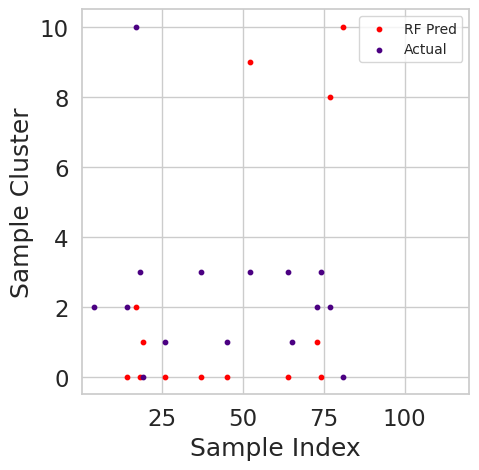

In [ ]:
fig = plt.figure(figsize = (5,5))
ax = plt.axes()
ax.scatter(rf_ind, rf_preds, c='red',  s=10, label="RF Pred")
ax.scatter(misclass_ind, misclass_actual, c='indigo', s=10, label="Actual")
plt.xlim(right=120)
plt.xlabel('Sample Index')
plt.ylabel('Sample Cluster')
plt.legend(fontsize="10")

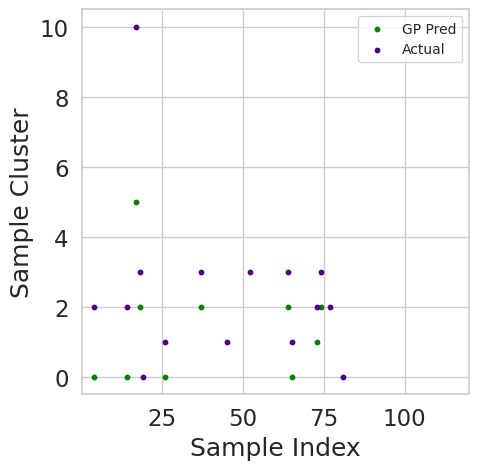

In [ ]:
fig = plt.figure(figsize = (5,5))
ax = plt.axes()
ax.scatter(gp_ind, gp_preds, c='green',  s=10, label="GP Pred")
ax.scatter(misclass_ind, misclass_actual, c='indigo', s=10, label="Actual")
plt.xlim(right=120)
plt.xlabel('Sample Index')
plt.ylabel('Sample Cluster')
plt.legend(fontsize="10")

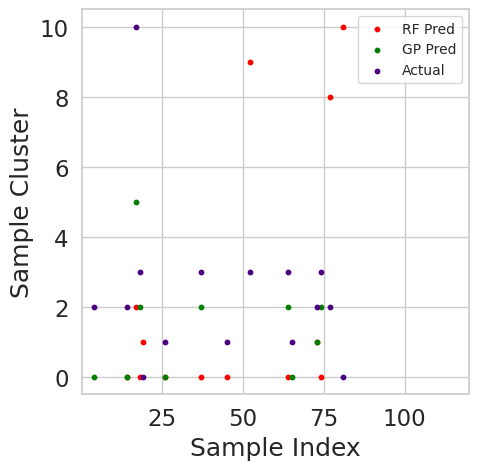

In [ ]:
fig = plt.figure(figsize = (5,5))
ax = plt.axes()
ax.scatter(rf_ind, rf_preds, c='red',  s=10, label="RF Pred")
ax.scatter(gp_ind, gp_preds, c='green',  s=10, label="GP Pred")
ax.scatter(misclass_ind, misclass_actual, c='indigo', s=10, label="Actual")
plt.xlim(right=120)
plt.xlabel('Sample Index')
plt.ylabel('Sample Cluster')
plt.legend(fontsize="10")

## Discussion:

After changing the encoding of our data, we can see a massive increase in our Dirichlet classification accuracy, and a stronger performance than random forest. If you're curious on how random forest performs under this data encoding, you can run the model prediction above. You will find that there is no significant difference between the encodings in terms of prediction accuracy and total error.

Dirichlet classification is very consistent, providing the same scores and same error every iteration. Random Forest, on the other hand, varies in total error, but tends to stay consistent with its total prediction accuracy. We also saw from the frequency table that Random Forest and Dirichlet both have very similar frequency errors.

Additionally, there may be questions regarding why we didn't one-hot encode all four values, and only the locations, when all of them are discrete data types. While time and day can be viewed as continuous variables, we wish for our locations to be treated as labels and not necessarily have numerical weight tied to them. This is because the clusters are arranged by frequency, but the frequency is not necessarily scale predictably with the cluster value. Empirically, this can be confirmed by testing it out above. You will find that the model performs worse using one-hot encodings of time and day.

In our opinion Gaussian Processes are strong condtendors for predictive capabilities within the realm of trajectory prediction. Future works may include combinations with other machine learning techniques to boost performance, additional measures for analyzing accuracy, travel time prediction (in conjunction with location prediction), and transportation modality identification.

## Notes

- GPs are popular in travel time prediction, but to our knowledge, have not yet been employed for travel trajectory and location prediction.

- Future works should include testing with deep learning processes such as RNN or LSTM which are SOTA for sequence-based learning. Emphasis on performance given limited data.

Note: Focus on explanation for our error and possibilities of inaccuracies